<a href="https://colab.research.google.com/github/WIVIV/Project_3_AFI/blob/master/Copy_of_Proj_3_WF_TL_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q pyyaml h5py 

**Use TensorFlow V2.x**

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension
%load_ext tensorboard
!rm -rf ./logs/ 

TensorFlow 2.x selected.


Imports

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.keras.models import Sequential

from tensorflow.keras import models
from tensorflow.keras import layers

from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime

Test GPU available

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Import images from DropBox

In [5]:
!wget "https://www.dropbox.com/s/ghfhjtoh1z59xeb/wildfire_smoke_data.tar"


--2020-02-13 23:54:32--  https://www.dropbox.com/s/ghfhjtoh1z59xeb/wildfire_smoke_data.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ghfhjtoh1z59xeb/wildfire_smoke_data.tar [following]
--2020-02-13 23:54:32--  https://www.dropbox.com/s/raw/ghfhjtoh1z59xeb/wildfire_smoke_data.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4a9be32e9b1a5ff0acdc3e642a.dl.dropboxusercontent.com/cd/0/inline/AyBapYQoyI7nYTGS8KIp2XFpptuAUXXAyDHUZq5bjmeaRMkMHGxmKrk6UjqJsPdpu527FhLLIOpVLap9eEkcTQ0yN2H-zsKz0xKUBujJV-O1nolbfnYX59Mx2LgKsFS9gHM/file# [following]
--2020-02-13 23:54:32--  https://uc4a9be32e9b1a5ff0acdc3e642a.dl.dropboxusercontent.com/cd/0/inline/AyBapYQoyI7nYTGS8KIp2XFpptuAUXXAyDHUZq5bjmeaRMkMHGxmKrk6UjqJsPdpu527FhLLIOpVLap9e

Inspect Image Archive File

In [6]:
!tar -xvf 'wildfire_smoke_data.tar'

wildfire_smoke_data/
wildfire_smoke_data/validate/
wildfire_smoke_data/.DS_Store
wildfire_smoke_data/train/
wildfire_smoke_data/train/smoke/
wildfire_smoke_data/train/.DS_Store
wildfire_smoke_data/train/no_smoke/
wildfire_smoke_data/train/no_smoke/1529000660_-00300.jpg
wildfire_smoke_data/train/no_smoke/1563134723_-00300.jpg
wildfire_smoke_data/train/no_smoke/1563227903_+00780.jpg
wildfire_smoke_data/train/no_smoke/1529018485_-02220.jpg
wildfire_smoke_data/train/no_smoke/1559166605_-00780.jpg
wildfire_smoke_data/train/no_smoke/1499545543_-00720.jpg
wildfire_smoke_data/train/no_smoke/1499545003_-01260.jpg
wildfire_smoke_data/train/no_smoke/1563134063_-00960.jpg
wildfire_smoke_data/train/no_smoke/1530738445_-00600.jpg
wildfire_smoke_data/train/no_smoke/1530901081_-00600.jpg
wildfire_smoke_data/train/no_smoke/1559167205_-00180.jpg
wildfire_smoke_data/train/no_smoke/1564867239_-01980.jpg
wildfire_smoke_data/train/no_smoke/1562958920_-00421.jpg
wildfire_smoke_data/train/no_smoke/1498416573_

Split data into train and vaildate

In [0]:
train_image_folder ='wildfire_smoke_data/train'
validate_image_folder = 'wildfire_smoke_data/validate'

In [0]:
train_smoke_dir = 'wildfire_smoke_data/train/smoke'  # directory with our training smoke pictures
train_nosmoke_dir = 'wildfire_smoke_data/train/no_smoke'  # directory with our training no smoke pictures
validation_smoke_dir = 'wildfire_smoke_data/validate/smoke' # directory with our validation smoke pictures
validation_nosmoke_dir = 'wildfire_smoke_data/validate/no_smoke' # directory with our validation no smoke pictures


In [0]:
num_smoke_tr = len(os.listdir(train_smoke_dir))
num_nosmoke_tr = len(os.listdir(train_nosmoke_dir))

num_smoke_val = len(os.listdir(validation_smoke_dir))
num_nosmoke_val = len(os.listdir(validation_nosmoke_dir))

total_train = num_smoke_tr + num_nosmoke_tr
total_val = num_smoke_val + num_nosmoke_val

In [36]:
print('total training smoke images:', num_smoke_tr)
print('total training nosmoke images:', num_nosmoke_tr)

print('total validation smoke images:', num_smoke_val)
print('total validation nosomke images:', num_nosmoke_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

Distribution = {
'Total training images': total_train,
'Total validation images': total_val,
'total training smoke images': num_smoke_tr,
'total training nosmoke images': num_nosmoke_tr,
'total validation smoke images': num_smoke_val,
'total validation nosomke images': num_nosmoke_val
}

total training smoke images: 575
total training nosmoke images: 501
total validation smoke images: 143
total validation nosomke images: 123
--
Total training images: 1076
Total validation images: 266


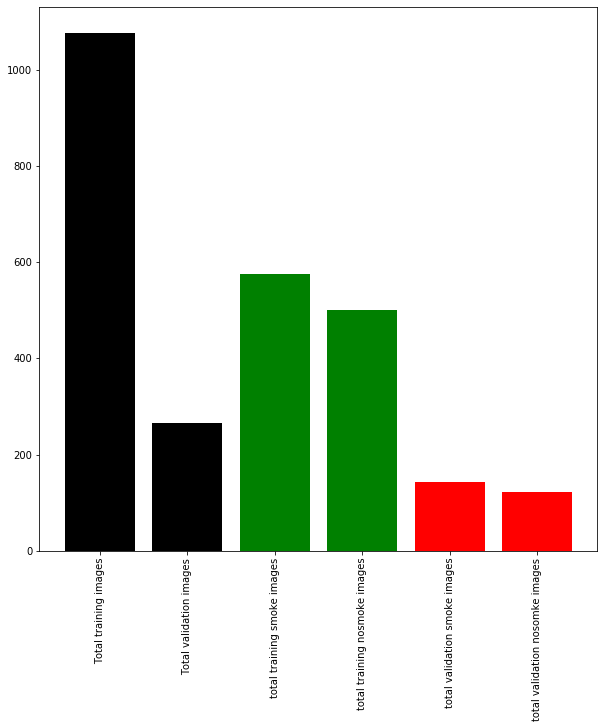

In [58]:
plt.figure(figsize=(10, 10))
plt.bar(range(len(Distribution)), list(Distribution.values()), align='center',color=['black', 'black', 'green', 'green', 'red','red'])
plt.xticks(range(len(Distribution)), list(Distribution.keys()),rotation=90)
plt.show()

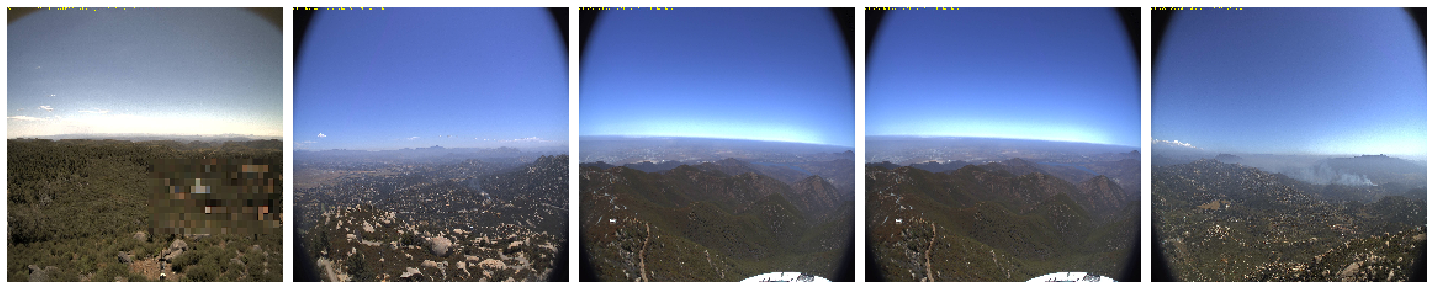

In [61]:
sample_training_images, _ = next(train_data_gen)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
  
plotImages(sample_training_images[:5])

**Create data generator**

In [0]:
#augment the images. Note best results were gained with limited preprocessing
train_image_generator = ImageDataGenerator(rescale=1./255,
                                            ##Have tried different combintions and values of these settings
                                            #rotation_range=40,
                                            #width_shift_range=0.2,
                                            #height_shift_range=0.2,
                                            #brightness_range=[0.3,-2],
                                            #shear_range=0.2,
                                            #zoom_range=0.2,
                                            #horizontal_flip=True,
                                            #fill_mode='nearest')
)
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

Set Paramaters

In [0]:
batch_size = 30
IMG_HEIGHT = 224
IMG_WIDTH = 224
class_mode='binary'


Create train and validate data generators

In [13]:
train_data_gen = train_image_generator.flow_from_directory(train_image_folder,
                                                           batch_size=batch_size,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode=class_mode)

Found 1074 images belonging to 2 classes.


In [14]:
val_data_gen = validation_image_generator.flow_from_directory(validate_image_folder,
                                                              batch_size=batch_size,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode=class_mode)

Found 266 images belonging to 2 classes.


Create Custom Built Model

In [15]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])


from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

Create logs for TensorBoard

In [0]:
logdir = os.path.join("tf_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [17]:
initial_epochs = 15

history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=initial_epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    verbose=1,
    callbacks=[tensorboard_callback]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 35 steps, validate for 8 steps
Epoch 1/15
35/35 [==============================] - 82s 2s/step - loss: 1.1755 - accuracy: 0.5469 - val_loss: 0.9819 - val_accuracy: 0.4375
Epoch 2/15
35/35 [==============================] - 79s 2s/step - loss: 0.6762 - accuracy: 0.6063 - val_loss: 0.6375 - val_accuracy: 0.5792
Epoch 3/15
35/35 [==============================] - 78s 2s/step - loss: 0.6381 - accuracy: 0.6561 - val_loss: 0.5274 - val_accuracy: 0.7542
Epoch 4/15
35/35 [==============================] - 78s 2s/step - loss: 0.5307 - accuracy: 0.7548 - val_loss: 0.6426 - val_accuracy: 0.5750
Epoch 5/15
35/35 [==============================] - 79s 2s/step - loss: 0.3980 - accuracy: 0.8151 - val_loss: 0.4062 - val_accuracy: 0.8167
Epoch 6/15
35/35 [==============================] - 79s 2s/step - loss: 0.2990 - accuracy: 0.8927 - val_loss: 0.2519 - val_accuracy: 0.8875
Epoch 7/15
35/35 [==============================] - 78s 2s/step - los

Plot results

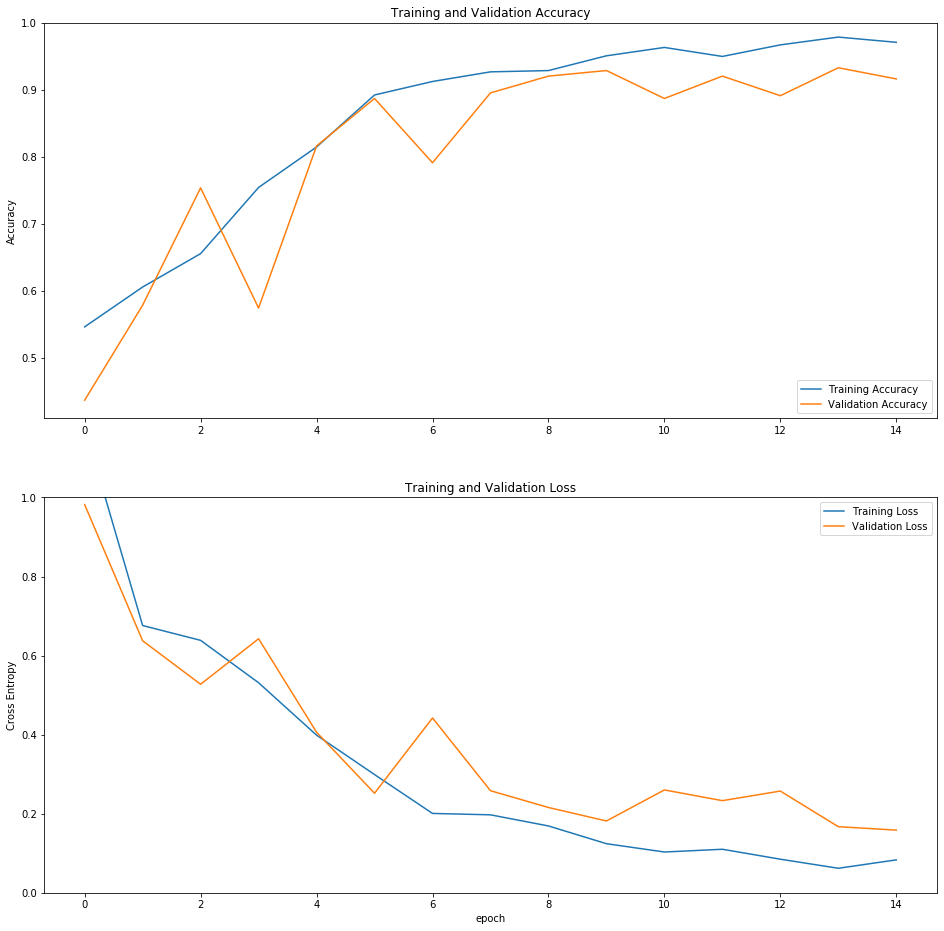

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Transfer Learning**

In [19]:
#Tranfser Learning using models that are composed of two parts:Convolutional base & Classifier.

from keras.applications import VGG19

#create a base model
base_model = tf.keras.applications.VGG19(input_shape=(IMG_HEIGHT, IMG_WIDTH,3), include_top=False)#image net weights removed

Using TensorFlow backend.


80142336/80134624 [==============================] - 2s 0us/step


In [20]:
batch_size=40

#class_mode='binary'




activation_function = 'sigmoid'
#loss_function = 'binary_crossentropy'


train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
            rescale=1.0/255.0,
            #shear_range=0.2, 
            #zoom_range=[0.9, 1.25],
            #brightness_range=[0.5, 1.5],
            horizontal_flip=True,
            vertical_flip=True
            )
     
validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
            rescale=1.0/255.0)


train_generator = train_image_generator.flow_from_directory(
            train_image_folder,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=batch_size,
            class_mode=class_mode)

validation_generator = validation_image_generator.flow_from_directory(
            validate_image_folder,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=batch_size,
            class_mode=class_mode)




Found 1074 images belonging to 2 classes.
Found 266 images belonging to 2 classes.


In [21]:
reload_checkpoint=True
img_input = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
global_average_layer = layers.GlobalAveragePooling2D()
prediction_layer = layers.Dense(1, activation=activation_function)

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])


print("Number of layers in the base model: ", len(base_model.layers))

base_model.trainable = False

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Number of layers in the base model:  22
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 20,024,897
Trainable params: 513
Non-trainable params: 20,024,384
_________________________________________________________________


In [22]:
tl_epochs = 4
stage_2_epochs = initial_epochs + tl_epochs
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

logdir = os.path.join("tf_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


history_tl = model.fit(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      validation_data=validation_generator,
      validation_steps=validation_steps,
      callbacks=[tensorboard_callback],
      epochs=stage_2_epochs,
      initial_epoch=history.epoch[-1],
      verbose=1,)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 26 steps, validate for 6 steps
Epoch 15/19
26/26 [==============================] - 84s 3s/step - loss: 0.6928 - accuracy: 0.5039 - val_loss: 0.6912 - val_accuracy: 0.4917
Epoch 16/19
26/26 [==============================] - 82s 3s/step - loss: 0.6904 - accuracy: 0.5213 - val_loss: 0.6926 - val_accuracy: 0.4917
Epoch 17/19
26/26 [==============================] - 81s 3s/step - loss: 0.6886 - accuracy: 0.5271 - val_loss: 0.6956 - val_accuracy: 0.5167
Epoch 18/19
26/26 [==============================] - 81s 3s/step - loss: 0.6890 - accuracy: 0.5242 - val_loss: 0.6985 - val_accuracy: 0.5125
Epoch 19/19
26/26 [==============================] - 81s 3s/step - loss: 0.6904 - accuracy: 0.5280 - val_loss: 0.6958 - val_accuracy: 0.4958


In [0]:
acc += history_tl.history['accuracy']
val_acc += history_tl.history['val_accuracy']

loss += history_tl.history['loss']
val_loss += history_tl.history['val_loss']

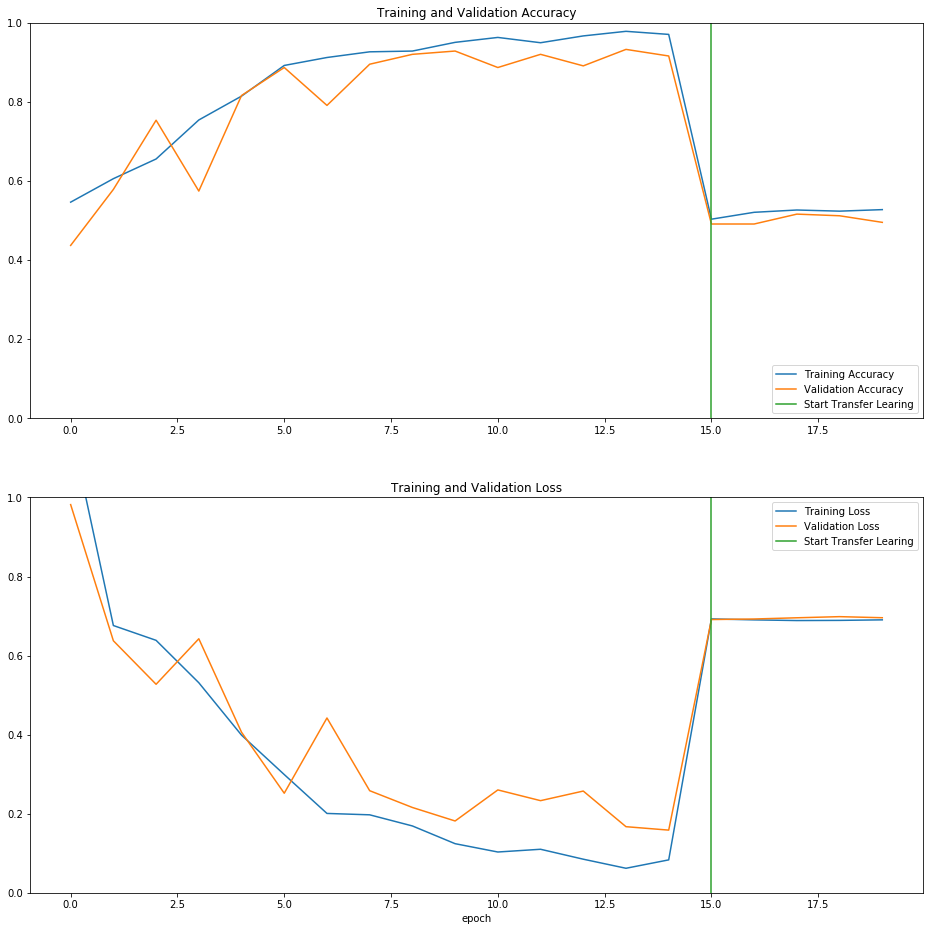

In [24]:
plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs,initial_epochs],
          plt.ylim(), label='Start Transfer Learing')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs,initial_epochs],
         plt.ylim(), label='Start Transfer Learing')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


**Fine Tuning**

In [25]:
#Fine-tune a subset of top layers
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune start from layer 10
fine_tune_at = 10

# Freeze layers before fine tuning layer
for layer in base_model.layers[:fine_tune_at]:
     layer.trainable = False

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Number of layers in the base model:  22
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 20,024,897
Trainable params: 18,289,409
Non-trainable params: 1,735,488
_________________________________________________________________


In [26]:
fine_tune_epochs = 5
stage_3_epochs = stage_2_epochs + fine_tune_epochs

steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

logdir = os.path.join("tf_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history_fine = model.fit(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      validation_data=validation_generator,
      validation_steps=validation_steps,
      callbacks=[tensorboard_callback],
      epochs=stage_3_epochs,
      initial_epoch=history_tl.epoch[-1],
      verbose=1,)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 26 steps, validate for 6 steps
Epoch 19/24
26/26 [==============================] - 82s 3s/step - loss: 7215.0109 - accuracy: 0.5116 - val_loss: 0.6925 - val_accuracy: 0.5250
Epoch 20/24
26/26 [==============================] - 80s 3s/step - loss: 0.7424 - accuracy: 0.5155 - val_loss: 8.4212 - val_accuracy: 0.4750
Epoch 21/24
26/26 [==============================] - 85s 3s/step - loss: 0.9625 - accuracy: 0.5271 - val_loss: 0.7121 - val_accuracy: 0.5250
Epoch 22/24
26/26 [==============================] - 83s 3s/step - loss: 0.6970 - accuracy: 0.5261 - val_loss: 0.7047 - val_accuracy: 0.5250
Epoch 23/24
26/26 [==============================] - 81s 3s/step - loss: 0.7798 - accuracy: 0.5406 - val_loss: 0.6996 - val_accuracy: 0.5250
Epoch 24/24
26/26 [==============================] - 81s 3s/step - loss: 0.7102 - accuracy: 0.5174 - val_loss: 0.6931 - val_a

In [0]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

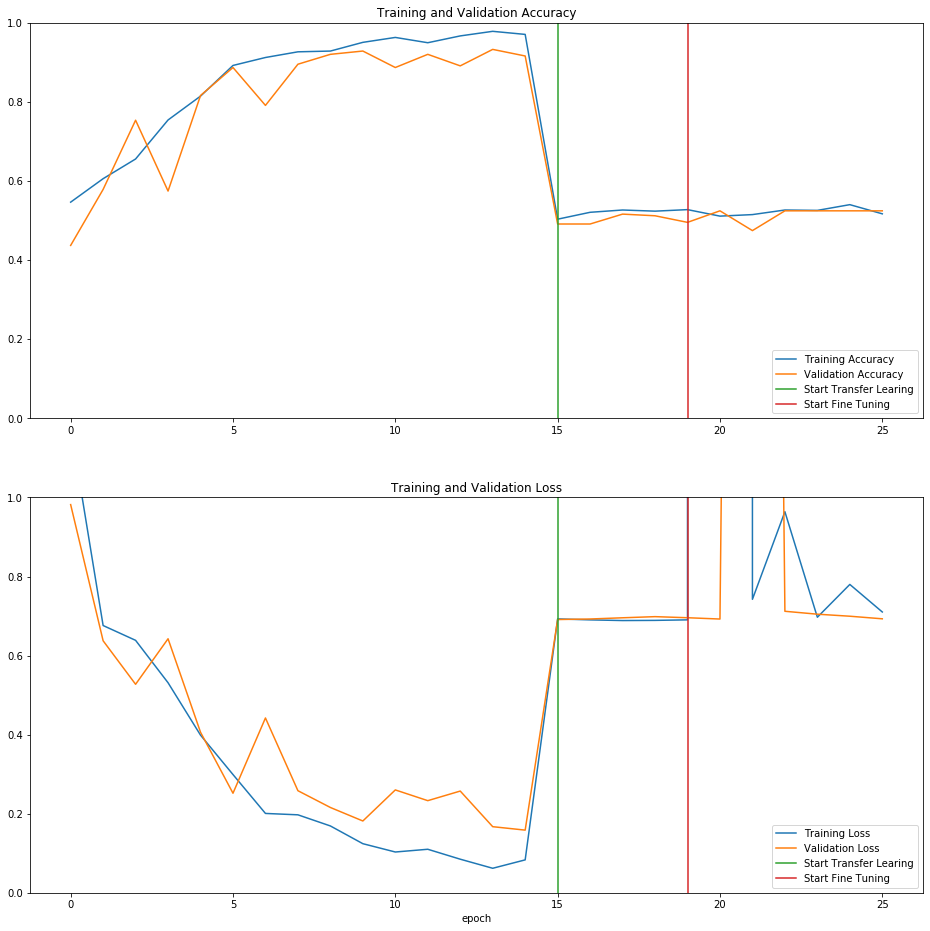

In [62]:
plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs,initial_epochs],
          plt.ylim(), label='Start Transfer Learing')
plt.plot([stage_2_epochs,stage_2_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs,initial_epochs],
          plt.ylim(), label='Start Transfer Learing')
plt.plot([stage_2_epochs,stage_2_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

BREAK